In [7]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#suppress warnings thrown when rainfall data is imported
# import logging
# logging.getLogger('rasterio._gdal').setLevel(logging.ERROR)
# import warnings

#get standard libraries
import datetime as dt
import fiona
import geopandas as gpd
import shapely.geometry
from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import numpy as np
import os
import pickle
import rasterio
import rasterio.features
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('/home/jovyan/Scripts/'))
import dea_plotting, dea_datahandling
# from FileDialogs import *

#Emma - I added this bit it in as cloud free landsat scenes are now obtained a different way
sys.path.insert(1, '/home/jovyan/Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#alias for datacube
dc = datacube.Datacube(app='dc-BoMrainfallandNbart')


In [8]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [9]:
def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.coords['y'][0]: list(points[1]),
        data.coords['x'][0]: list(points[0])        
    }
#     return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
#                            method=method,
#                            tolerance=tolerance,
#                            **indexers)
    return indexers

In [12]:
#transects file will be the file containing our transects
transects_file = '/home/jovyan/WA1.shp'
transects_df = gpd.read_file(transects_file)
transects_df.crs

#need to be WGS84 coordinate system for transects as it assumes this system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
transects_df

#do this to check its correct and what i think it should be

,id,WA1,Name,geometry
0,1,None,WA1,"LINESTRING (132.27279 -12.21566, 132.26347 -12..."


In [14]:
#Define temporal range
start_of_epoch = '2016-8-01' 
end_of_epoch =  '2016-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 2016-8-01 to 2016-10-01


In [15]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

#this statement asks you to choose a shapefile. put in a number and press enter.
i = int(input("choose the index of the transect you would like to plot:"))
#for i in range(len(transects)):

geom1 = shape(transects[i]['geometry'])
geom_query1 = geom_query(geom1)
query = {
    'time': (start_of_epoch, end_of_epoch),  
}
query.update(geom_query(geom1, geom_crs=transects.crs_wkt)) 

choose the index of the transect you would like to plot: 0


In [16]:
#use the transect dataframe to get transect metadata
transect_index = transects_df.index[i]
transect_name = transects_df['Name'][i] 
try:
    print(transect_name)
except TypeError as err:
    print("TypeError: {0}".format(err))
    print(transect_name)

#create a filename for the transect
shape_name = transect_name.split()
shape_name ='_'.join(shape_name)
shape_name=shape_name+'_ix'+str(transect_index)
print(shape_name)

#setup a save directory for our data
savepath ='./'+shape_name+'_/'
try:
        os.mkdir(savepath)
except OSError as err:
        print("OS error: {0}".format(err))

WA1
WA1_ix0


In [17]:
print(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl')

./WA1_ix0_/hov_data_WA1_ix0_2016-8-01_2016-10-01.pkl


In [18]:
#I changed the code a lot from the github version because i dont want rainfall

#I know that it should be dea_datahandling - this is the new code instead of DEADataHandling
#I also know that the clearlandsat code is now changed to load_ard
#I needed to add in the landsat version that i wanted, also change to remove the masked_prop to min_gooddata
#I could delete all the other stuff because it related to rainfall which i am not using and its also not in the data repositiory now


    
#use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
ds = dea_datahandling.load_ard(dc=dc, products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],min_gooddata=0.99, output_crs='EPSG:3577',
          resolution=(-30, 30),**query)
print('loaded SR data from DEA, loading rainfall data')
   

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step


CPLReleaseMutex: Error = 1 (Operation not permitted)


Filtering to 5 out of 13 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 5 time steps
loaded SR data from DEA, loading rainfall data


In [19]:
#I did this to check it works
ds

In [36]:
dist = [i for i in range(0, int(geom_w.length), 25)]
points = list(zip(*[geom_w.interpolate(d).coords[0] for d in dist])) #py3

In [45]:
ds.sel(xr.DataArray(dist, name='distance', dims=['distance']),
                method='nearest', tolerance=None)

ValueError: the first argument to .sel must be a dictionary

In [52]:
import geopandas as gdf
from dea_tools.spatial import xr_rasterize
shp = gpd.read_file('/home/jovyan/WA1.shp')
shp_rast = xr_rasterize(gdf=shp, da=ds, crs=ds.crs)

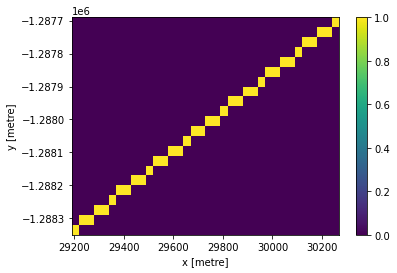

In [54]:
shp_rast.plot()

In [56]:
ds_masked = ds.where(shp_rast)

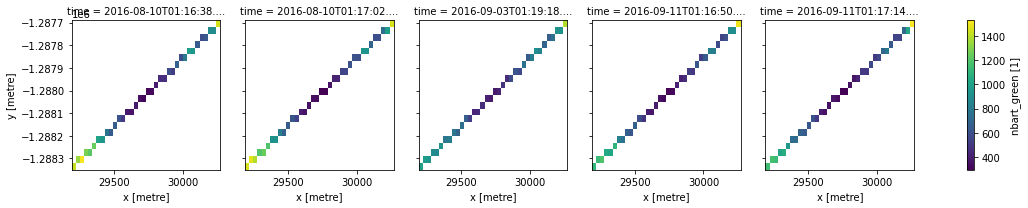

In [58]:
ds_masked.nbart_green.plot(col='time')

In [ ]:
# def transect(data, geom, resolution, method='nearest', tolerance=None):
#     """
#     gets the transect
#     """
#     #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.coords['y'][0]: list(points[1]),
        data.coords['x'][0]: list(points[0])        
    }
#     return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
#                            method=method,
#                            tolerance=tolerance,
#                            **indexers)
    return indexers

In [13]:
#This controls the colour map used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
#Be aware that clip = True might be causing issues
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N, clip=True)

In [19]:
transect

<function __main__.transect(data, geom, resolution, method='nearest', tolerance=None)>

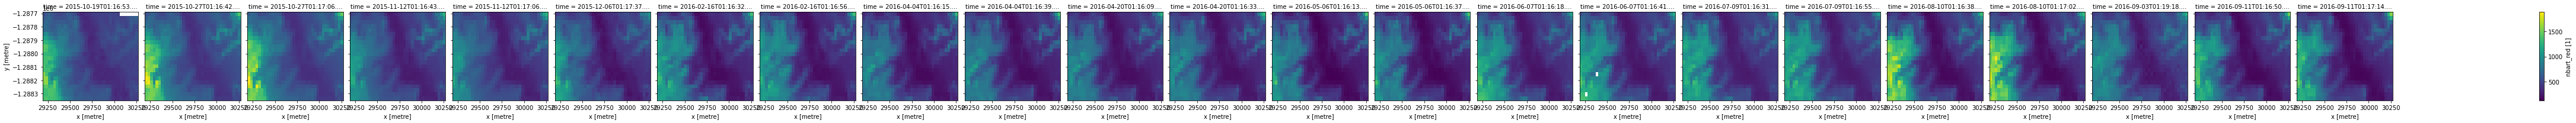

In [30]:
ds.nbart_red.plot(col='time')

In [24]:
## Compress 
ds.crs
crs = ds.crs
crs_wkt = ds.crs
geom_w = warp_geometry(geom1, query['crs'], crs_wkt)
# hov_ds= transect(ds, geom_w, 25)   

In [60]:
#calculate NDVI here
hov_multi_ndvi = ((ds_masked.nbart_nir-ds_masked.nbart_red)/(ds_masked.nbart_nir+ds_masked.nbart_red))
# hov_multi =hov_ds
# hov_multi_ndvi_drop = hov_multi_ndvi

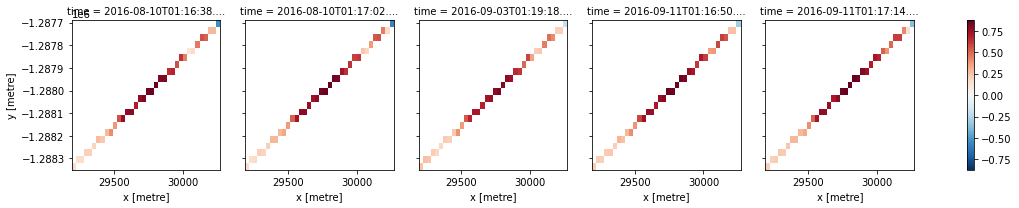

In [62]:
hov_multi_ndvi.plot(col='time')

In [82]:
ds.sel(time='2016-08-10T01:16:38.866271000')

<xarray.Dataset>
Dimensions:                     (y: 22, x: 36)
Coordinates:
    time                        datetime64[ns] 2016-08-10T01:16:38.866271
  * y                           (y) float64 -1.288e+06 -1.288e+06 ... -1.288e+06
  * x                           (x) float64 2.920e+04 2.924e+04 ... 3.026e+04
    spatial_ref                 int32 3577
Data variables: (12/20)
    nbart_blue                  (y, x) float32 242.0 291.0 317.0 ... 257.0 268.0
    nbart_green                 (y, x) float32 530.0 634.0 665.0 ... 476.0 512.0
    nbart_red                   (y, x) float32 336.0 421.0 465.0 ... 319.0 354.0
    nbart_nir                   (y, x) float32 2.679e+03 2.663e+03 ... 2.359e+03
    nbart_swir_1                (y, x) float32 834.0 971.0 ... 656.0 689.0
    nbart_swir_2                (y, x) float32 333.0 383.0 407.0 ... 279.0 295.0
    ...                          ...
    oa_satellite_azimuth        (y, x) float32 278.4 278.4 278.4 ... 278.4 278.4
    oa_satellite_view           (y, x) float32 1.148 1.15 1.153 ... 1.239 1.242
    oa_solar_azimuth            (y, x) float32 47.69 47.69 47.69 ... 47.67 47.67
    oa_solar_zenith             (y, x) float32 40.53 40.53 40.53 ... 40.52 40.52
    oa_time_delta               (y, x) float32 10.39 10.39 10.39 ... 10.46 10.46
    oa_fmask                    (y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

transect image: 


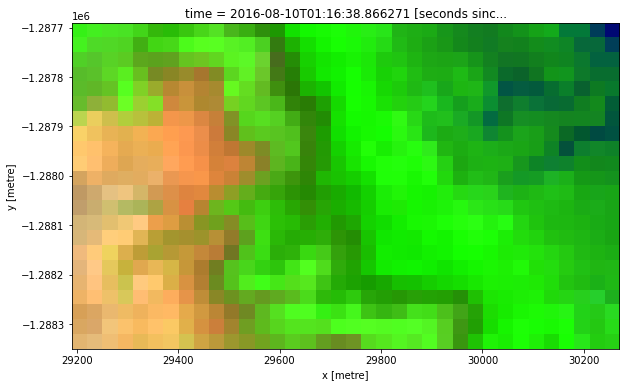

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    rgb(ds.sel(time='2016-08-10T01:16:38.866271000'), bands=['nbart_swir_1','nbart_nir','nbart_green'])
#     plt.scatter(x=ds.coords['x'], y=ds.coords['y'], c='r',
#                linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

# #Make a hovmoller plot and save it to file.
# #Use firstyear and last year to zoom into periods of interest
# firstyearhov = start_of_epoch#'1987-06-01'
# lastyearhov = end_of_epoch #'2016-12-31'
# fig = plt.figure(figsize=(11.27,11.69))
# gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
# ax1 = plt.subplot(gs[0, 0])
# ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
# ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

# ax2 = plt.subplot(gs[0, 1])
# hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
# #fig.delaxes(fig.axes[]) #remove current colour bar
# plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
# ax2.set_anchor("SE")
# #make a title replacing underscores with spaces
# plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

# #save plot to file
# plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
#             bbox_inches='tight')
# plt.show()

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm, vmin=-1, vmax =1)
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

transect image: 


NameError: name 'DEAPlotting' is not defined

In [17]:
try:
    #make a dictionary of the data we want to save
    hov_data = {'ds':ds, 'Studysite_rain':Studysite_rain,'rain_sp':rain_sp,'month_sp':month_sp,
                'year_avg':year_avg,'year_avg_sp':year_avg_sp,'hov_ds':hov_ds, 'start_of_epoch': start_of_epoch, 
                'end_of_epoch':end_of_epoch,'ndvi_cmap':ndvi_cmap, 'ndvi_norm':ndvi_norm, 'ndvi_bounds':ndvi_bounds}

    f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'wb')
    pickle.dump(hov_data,f) 
    print('saved data to file')
    #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()
except:
    print('did not save to file')

did not save to file
